In [2]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from xgboost import XGBRegressor
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import math
from sklearn.metrics import f1_score


In [6]:
df = pd.read_csv('speed_dating_data.csv', encoding = "ISO-8859-1")

data1 = pd.concat([df.iloc[:,0], #ID
                  df.iloc[:,2], #gender
                  df.iloc[:,5],
                  df.iloc[:,9:10], #order of date
                  df.iloc[:, 11:12], #partner's id
                  df.iloc[:, 12:13], #match, 
                  df.iloc[:,13:17], #int_corr, samerace, age of partner, race of partner 
                  df.iloc[:,17:23], #stated preferences
                  df.iloc[:,23:24], #decision of partner - dec-o
                  df.iloc[:,24:28], #attr_o..fun_o
                  df.iloc[:,28:30], #DROPPING AMB_O and SHAR_O
                  df.iloc[:,30:32],
                  #df.iloc[:,24:32],   # rating by partner for 6 attributes, probability of matching with partner #amb-o has lots of missing values - try eliminating
                  #df.iloc[:,32:35], # met, age, field
                  df.iloc[:,39:42],#race, importance of race, importance of religion
                  #df.iloc[:,42:43], #from   (DROPPED ZIPCODE AND INCOME AS THEY HAVE TOO MANY MISSING VALUES)
                  df.iloc[:,45:48], #goal, date, go_out
                  #df.iloc[:,48:50], #career, career_coded
                  df.iloc[:,50:67], #interests
                  #df.iloc[:,67:69], #exphappy, expnum (DROPPED - TOO MANY MISSING VALUES)
                  df.iloc[:,69:74],  #what subject looks for in the opposite sex - 6 attributes
                  df.iloc[:,74:75],  #shar1_1
                  df.iloc[:,81:87], #attr2_1,..shar2_1
                  df.iloc[:,87:92],  #attr3_1.. #91 is amb3_1 (how do you measure up)
                  df.iloc[:,97:98], #decision of subject - dec
                  df.iloc[:,98:102], #ratings by subject for partner for the 6 attributes. 101 is fun
                  df.iloc[:,102:104], #amb,shar (103 is shared - dropped)
                  df.iloc[:,104:107]],axis=1) #like, prob, met
data1 = data1.dropna()
data1_X = data1.drop(['match','iid','wave','pid','dec_o','dec','like_o','prob_o','like','prob'],axis=1)
y1 = data1['match']


print("Baseline accuracy for match: %f" % (1 - data1.match.sum()/data1.match.count()))
print("Baseline accuracy for decision: %f" % (1 - df.dec_o.sum()/df.dec_o.count()))

Baseline accuracy for match: 0.823593
Baseline accuracy for decision: 0.580449


['intel_o', 'fun_o', 'amb_o', 'shar_o', 'art', 'theater', 'music', 'intel', 'fun', 'amb', 'shar'] correlated features


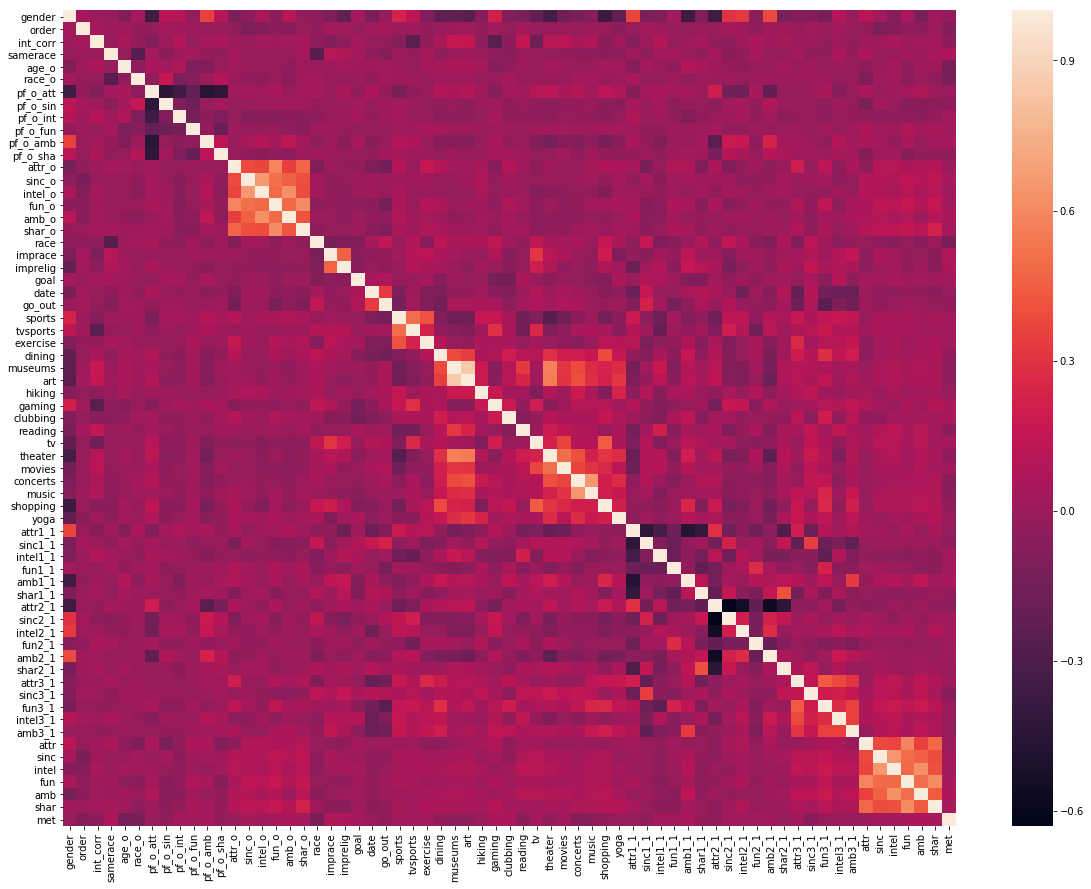

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data1_X,
                                                    y1,
                                                    test_size=.2,
                                                    stratify=y1)

plt.subplots(figsize=(20,15))
import seaborn as sns
corr = X_train.corr()
corr_abs = corr.abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than a threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.55)]

print(to_drop, "correlated features")
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

corr_matrix = data1.corr().abs()
#print(corr_matrix['match'].sort_values(ascending=False).head(15))

#try dropping fun_o, shar, attr_o


## Feature Importance 

shar_o      0.043596
attr_o      0.042427
fun_o       0.041168
attr        0.040933
shar        0.040603
fun         0.039882
intel_o     0.020813
sinc_o      0.019090
intel       0.018889
order       0.018773
sinc        0.018665
pf_o_sha    0.018624
amb_o       0.018605
pf_o_fun    0.018079
pf_o_sin    0.017505
dtype: float64


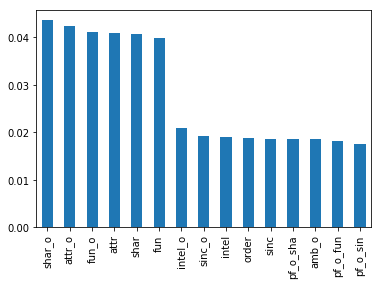

In [11]:

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
#print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=data1_X.columns)
print(feat_importances.nlargest(15))
feat_importances.nlargest(15).plot(kind='bar')
plt.show()


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

Y = y_train
X = X_train
estimator = SVR(kernel = "linear")
selector = RFE(estimator, 15, step=1)
selector = selector.fit(X, Y)
print(selector.ranking_)
print(selector.support_)

In [ ]:
bool_list = selector.support_
col_num = [i for i, x in enumerate(bool_list) if x]
X_train.iloc[:,col_num]


##SELECT these features -
X=data1[['gender','age_o','int_corr','samerace','date','attr3_1','sinc3_1','fun3_1','intel3_1','amb3_1','attr','sinc','intel','fun','amb','shar','attr1_1','sinc1_1','intel1_1','fun1_1','amb1_1','shar1_1','pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha']]